## Assumptions:

* Total Flood Risk = Perc_Cropland_Flooded * 0.5 + Perc_People_Flooded * 0.5
* Those ranking on the top 30% of this list = High Flood Risk Districts
* Those ranking on the bottom 70% of this list = Low Flood Risk Districts


## Hypothesis:

Remotely-sensed flood information, when provided to first responders...reduces food insecurity in the **flood-prone regions of Ghana** relative to **the non-flood-prone regions.**


In [1]:
import pandas as pd

## load in Perc_People_Flooded_NRT

path_input = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/01-TC-Assignment/Perc-Flooded-NRT/People/'
name_input_file = 'Perc_People_Flooded.csv'
people_NRT = pd.read_csv(path_input+name_input_file, header=0)

## load in Perc_Cropland_Flooded_NRT

path_input = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/01-TC-Assignment/Perc-Flooded-NRT/Cropland/'
name_input_file = 'Perc_Cropland_Flooded.csv'
cropland_NRT = pd.read_csv(path_input+name_input_file, header=0)

## output files
path_output = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/01-TC-Assignment/'
name_output_file = 'Final_Adm2_TC_Assignment.csv'


### Using near-real time data

In [2]:
# get list of districts from cropland data that have missing values
dist_to_drop = cropland_NRT[cropland_NRT['Perc_Flooded'].isna()]['Region'].tolist() 
cropland_NRT = cropland_NRT.dropna()

# drop these districts from the people data
for i in people_NRT['Region']: # if row contains missing data
    if i in dist_to_drop:
        people_NRT = people_NRT[people_NRT['Region'] != i] # drop it from the study
        
people_NRT # only working with 202 districts for the treatment-control analysis

import numpy as np

people_NRT = people_NRT.sort_values(by=['Region']) # sort values by district name
cropland_NRT = cropland_NRT.sort_values(by=['Region'])

assert list(people_NRT['Region']) == list(cropland_NRT['Region']) # ensure districts match up

# calculate total flood risk by applying arbitrary 50-50 formula
df_floodrisk = cropland_NRT.merge(people_NRT, left_on='Region', right_on='Region')
df_floodrisk.columns = ['Region', 'Perc_Cropland_Flooded', 'Perc_Population_Flooded']

df_floodrisk

,Region,Perc_Cropland_Flooded,Perc_Population_Flooded
0,Abura / Asebu / Kwamankese,0.000000,0.001296
1,Accra Metropolis,0.000208,0.002028
2,Ada East,0.003864,0.010217
3,Ada West,0.008850,0.013472
4,Adaklu,0.001926,0.000266
...,...,...,...
197,West Gonja,0.001959,0.000662
198,West Mamprusi,0.079197,0.005232
199,Yendi Municipal,0.011735,0.008060
200,Yilo Krobo,0.000026,0.000000


In [3]:
# ASSUMPTIONS -----------------

treatment_control_cutoff = 0.65 # percentile threshold above which districts belong to treatment group

cropland_weights = 0.4
people_weights = 1-cropland_weights

print('Treatment cutoff assigned: Districts in the', str(int(treatment_control_cutoff*100))+'th percentile and above w.r.t. total flood risk')
print('Weights assigned - cropland: ', str(cropland_weights))
print('Weights assigned - people: ', str(people_weights))

Treatment cutoff assigned: Districts in the 65th percentile and above w.r.t. total flood risk
Weights assigned - cropland:  0.4
Weights assigned - people:  0.6


In [4]:
# apply arbitrary risk formula

x = pd.DataFrame(np.array(df_floodrisk)[:, 1:2] * cropland_weights + np.array(df_floodrisk)[:, 2:3] * people_weights) 
x.columns = ['Total_Flood_Risk']

tot_flood_risk = pd.concat([df_floodrisk,x], axis=1).sort_values(by=['Total_Flood_Risk'], ascending=False)
tot_flood_risk = tot_flood_risk[['Region', 'Total_Flood_Risk']]
tot_flood_risk['Treatment'] = None
n_treatment = round(len(tot_flood_risk) * treatment_control_cutoff) # flood prone districts -- districts ranking in the top 30% of the total flood risk metric
n_control = len(tot_flood_risk) - n_treatment # non-flood prone districts

# generate boolean treatment-control assignment variable to use moving forward

tot_flood_risk['Treatment'].loc[tot_flood_risk.index[0:n_treatment]] = 1
tot_flood_risk['Treatment'].loc[tot_flood_risk.index[n_treatment:len(tot_flood_risk)]] = 0
tot_flood_risk = tot_flood_risk.sort_values(by='Total_Flood_Risk', ascending=False)
tot_flood_risk

,Region,Total_Flood_Risk,Treatment
147,Saboba,0.0499972,1
94,Karaga,0.0365746,1
198,West Mamprusi,0.0348179,1
11,Agona West,0.03154,1
67,Chereponi,0.0294723,1
...,...,...,...
93,Kadjebi,0,0
28,Asokore Mampong Municipal,0,0
50,Bia West,0,0
89,Jaman South,0,0


In [5]:
# assert to ensure all districts were assigned to treatment vs control

assert tot_flood_risk.groupby('Treatment').size()[0]+tot_flood_risk.groupby('Treatment').size()[1] == len(tot_flood_risk)

print(tot_flood_risk.groupby('Treatment').size())

# write to disk
tot_flood_risk.to_csv(path_output+name_output_file, index = False, header=True)

Treatment
0     71
1    131
dtype: int64


In [6]:
# map groups -----

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# file paths and names

# path_input = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/01-TC-Assignment/Perc-Flooded-NRT/Cropland/'
# name_input_file = 'Perc_Cropland_Flooded.csv'

path_shp = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/00-Data-Sources/00-Cloud-to-Street/01-District-level/Districts-Shapefiles/216distboufinal-v2.shp'

path_output = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/01-TC-Assignment/Perc-Flooded-NRT/Cropland/perc_cropland_flooded_shp/'
name_output_csv = 'perc_cropland_flooded.csv'
name_output_file = 'perc_cropland_flooded.shp'


In [7]:
tot_flood_risk

,Region,Total_Flood_Risk,Treatment
147,Saboba,0.0499972,1
94,Karaga,0.0365746,1
198,West Mamprusi,0.0348179,1
11,Agona West,0.03154,1
67,Chereponi,0.0294723,1
...,...,...,...
93,Kadjebi,0,0
28,Asokore Mampong Municipal,0,0
50,Bia West,0,0
89,Jaman South,0,0


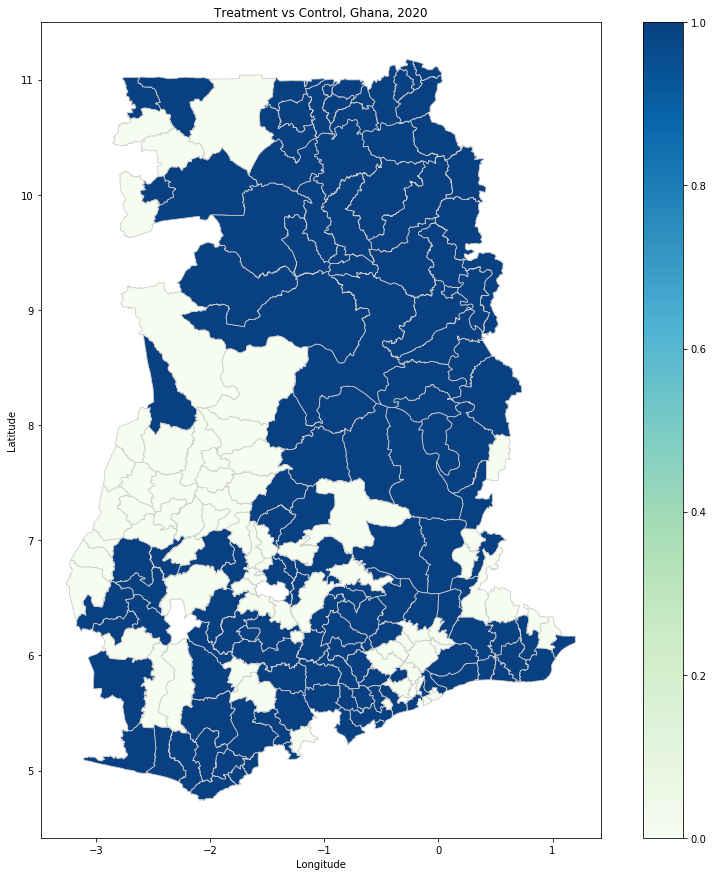

In [8]:
# # load total population data
# total = pd.read_csv(path_input+name_input_file, header=0)

# clean districts shapefile
ghana_dist = gpd.read_file(path_shp)
ghana_dist['DISTRICT'] = ghana_dist['DISTRICT'].str.title()

# map using geopandas
merged = ghana_dist.set_index('DISTRICT').join(tot_flood_risk.set_index('Region'))
merged.index.name = 'DISTRICT'
merged.reset_index(inplace=True)

merged = merged.sort_values(by=['Treatment'], ascending=False)

# set a variable that will call whatever column we want to visualise on the map
variable = 'Treatment'
colorscale = 'GnBu'

# set the range for the choropleth
vmin, vmax = min(merged[variable]), max(merged[variable])

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 15))

# create map
merged.plot(column=variable, cmap=colorscale, linewidth=0.8, ax=ax, edgecolor='0.8')
plt.title('Treatment vs Control, Ghana, 2020')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

sm = plt.cm.ScalarMappable(cmap=colorscale, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm)

plt.show()

